In [1]:
# import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

# display settings
%matplotlib inline
%load_ext nb_black
pd.options.display.max_columns = 999

<IPython.core.display.Javascript object>

In [2]:
# read data
try:
    DATA_DIR = "../data"
    FILENAME = "clothing_reviews.csv"
    df = pd.read_csv(os.path.join(DATA_DIR, FILENAME))
except FileNotFoundError as e:
    print(e)

<IPython.core.display.Javascript object>

In [3]:
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


<IPython.core.display.Javascript object>

In [4]:
from data import prepare_data

<IPython.core.display.Javascript object>

In [5]:
# prepare data for machine learning
X_train, y_train, X_valid, y_valid, X_test, y_test = prepare_data(df)

<IPython.core.display.Javascript object>

In [6]:
print("Type of training set:", type(X_train))
print("Training size:", len(X_train))

Type of training set: <class 'list'>
Training size: 14489


<IPython.core.display.Javascript object>

## NMF

In [7]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

<IPython.core.display.Javascript object>

In [8]:
from time import time

n_features = 1000
n_components = 10
n_top_words = 20

# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, stop_words="english"
)

t0 = time()
tfidf = tfidf_vectorizer.fit_transform(X_train)
print("done in %0.3fs." % (time() - t0))

Extracting tf-idf features for NMF...
done in 0.898s.


<IPython.core.display.Javascript object>

In [9]:
# Fit the NMF model
print("Fitting the NMF model (Frobenius norm) with tf-idf features")

t0 = time()
nmf = NMF(n_components=n_components, alpha=0.1, l1_ratio=0.5, random_state=42)
nmf.fit(tfidf)
print("done in %0.3fs." % (time() - t0))

Fitting the NMF model (Frobenius norm) with tf-idf features


/Users/bholaprasad/Documents/workspace/projects/womens-ecommerce-clothing-reviews/clothing_venv/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


done in 1.090s.


<IPython.core.display.Javascript object>

In [10]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

<IPython.core.display.Javascript object>

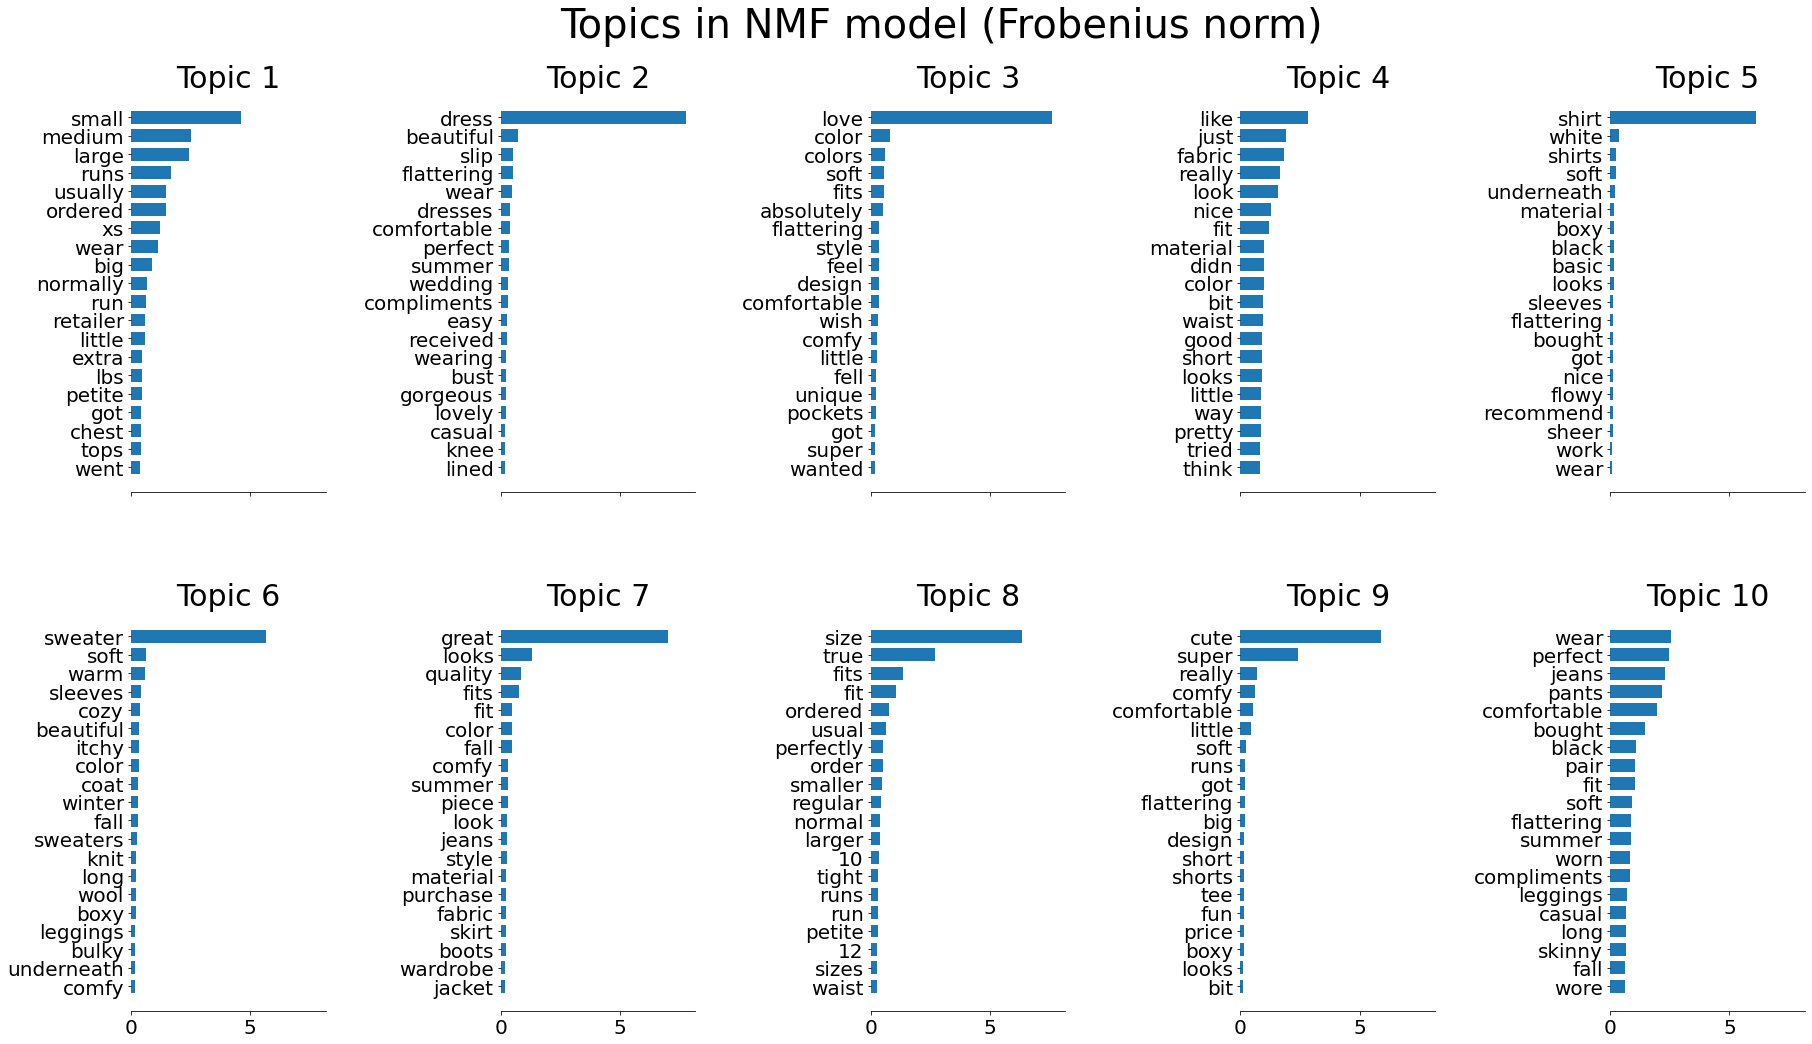

<IPython.core.display.Javascript object>

In [11]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

plot_top_words(
    nmf, tfidf_feature_names, n_top_words, "Topics in NMF model (Frobenius norm)"
)

In [12]:
# Fit the NMF model
print(
    "Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features"
)

t0 = time()
nmf = NMF(
    n_components=n_components,
    random_state=42,
    beta_loss="kullback-leibler",
    solver="mu",
    max_iter=1000,
    alpha=0.1,
    l1_ratio=0.5,
)
nmf.fit(tfidf)
print("done in %0.3fs." % (time() - t0))

Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features


/Users/bholaprasad/Documents/workspace/projects/womens-ecommerce-clothing-reviews/clothing_venv/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


done in 6.184s.


<IPython.core.display.Javascript object>

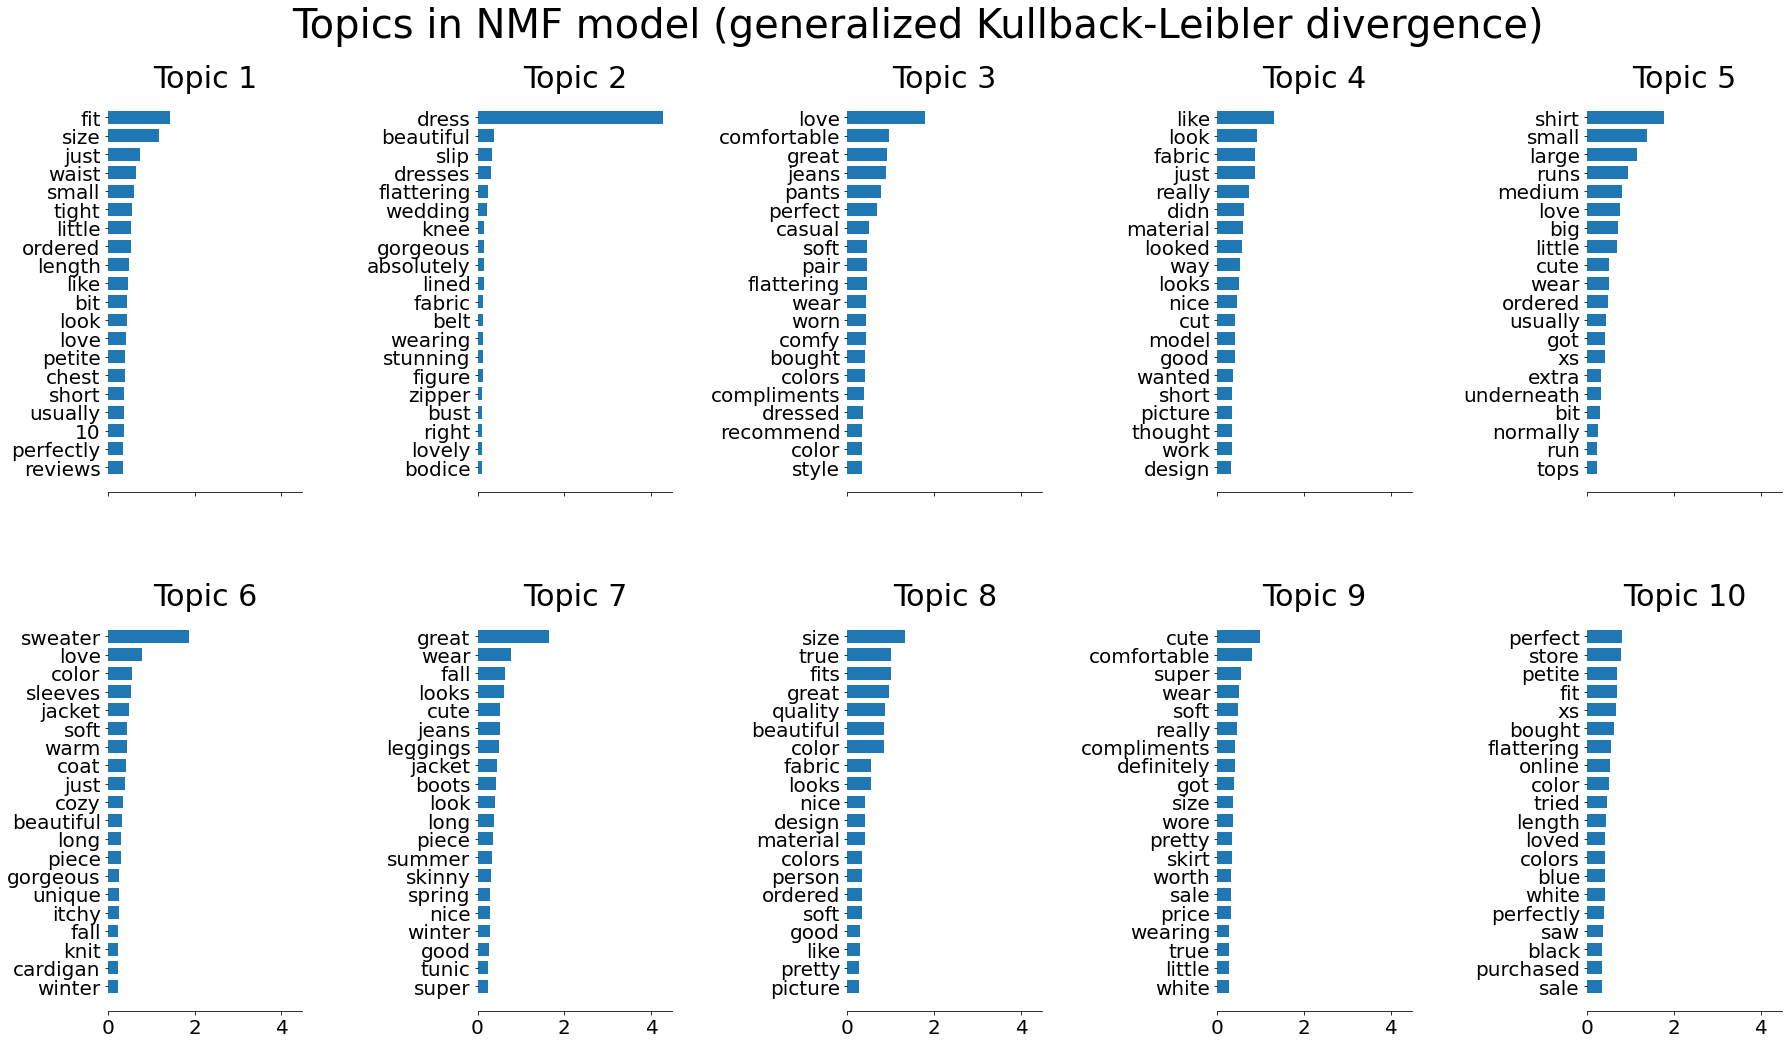

<IPython.core.display.Javascript object>

In [13]:
plot_top_words(
    nmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in NMF model (generalized Kullback-Leibler divergence)",
)

## LDA 

In [15]:
# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, stop_words="english"
)
t0 = time()
tf = tf_vectorizer.fit_transform(X_train)
print("done in %0.3fs." % (time() - t0))
print()

Extracting tf features for LDA...
done in 0.858s.



<IPython.core.display.Javascript object>

In [16]:
print("Fitting LDA models with tf features")

lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=42,
)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

Fitting LDA models with tf features
done in 31.546s.


<IPython.core.display.Javascript object>

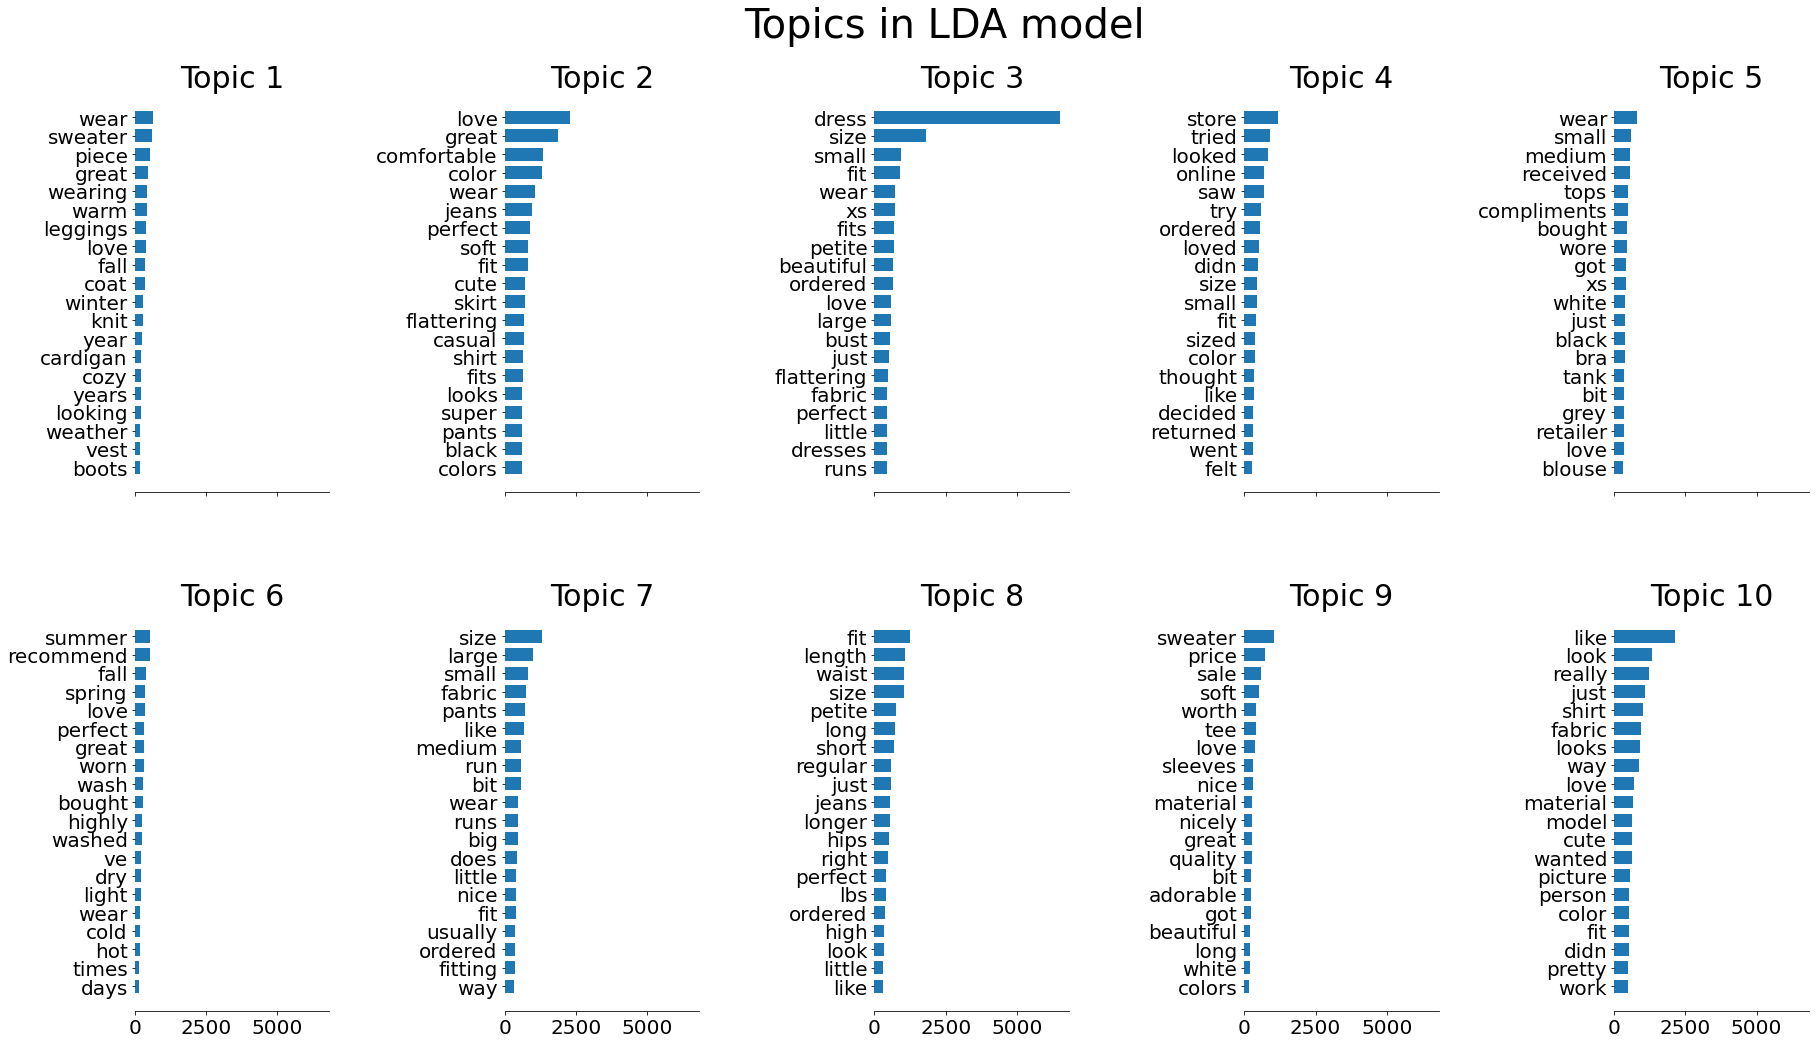

<IPython.core.display.Javascript object>

In [17]:
tf_feature_names = tf_vectorizer.get_feature_names()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")